# Imports #

In [121]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import  accuracy_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

# Load the dataset from the specified file path #

In [82]:
df = pd.read_csv('data/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


# Analyze the distribution of the target variable #

*Check the percentage distribution of the target variable to ensure class balance*


In [83]:
target_distribution = df['target'].value_counts(normalize=True) * 100
print("Target variable distribution (%):\n", target_distribution)

Target variable distribution (%):
 target
1    51.317073
0    48.682927
Name: proportion, dtype: float64


# Plot the correlation matrix for the given DataFrame. #

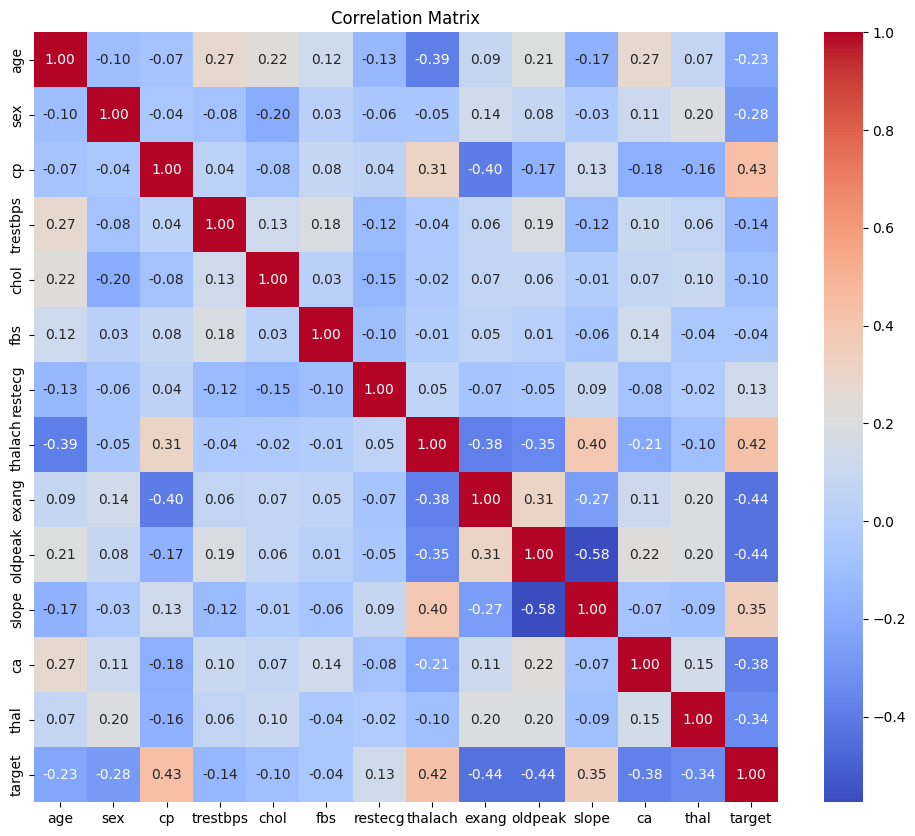

In [84]:
def plot_correlation_matrix(df):

    plt.figure(figsize=(12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()
plot_correlation_matrix(df)

# Split the data into training and testing sets #

*Split the data into training and testing sets using a 70/30 ratio and stratify based on the target variable*

In [86]:
X, y = df.drop('target', axis=1), df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train multiple machine learning models. #

In [87]:
#Random Forest Classifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)


#Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X_train, y_train)

#Standardize Data for Models Requiring Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)


LogisticRegression()

# Evaluate trained models and print classification reports. #

In [88]:
#Generate detailed evaluation metrics for each model.
models = {
    "Random Forest": forest,
    "Gradient Boosting": gradient_boosting,
    "Logistic Regression": logistic_regression,
}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled if name in ["Logistic Regression"] else X_test)
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 55)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       150
           1       1.00      0.96      0.98       158

    accuracy                           0.98       308
   macro avg       0.98      0.98      0.98       308
weighted avg       0.98      0.98      0.98       308

-------------------------------------------------------
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       150
           1       0.96      0.97      0.97       158

    accuracy                           0.96       308
   macro avg       0.96      0.96      0.96       308
weighted avg       0.96      0.96      0.96       308

-------------------------------------------------------
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       150
    

In [89]:
def evaluate_model_performance(models, X_test, X_test_scaled, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test_scaled if name in ["Logistic Regression"] else X_test)
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.9f}")
        print(f"Precision: {precision_score(y_test, y_pred):.9f}")
        print(f"Recall: {recall_score(y_test, y_pred):.9f}")
        print(f"F1 Score: {f1_score(y_test, y_pred):.9f}")
        print("-" * 25)


evaluate_model_performance(models, X_test, X_test_scaled, y_test)

Model: Random Forest
Accuracy: 0.980519481
Precision: 1.000000000
Recall: 0.962025316
F1 Score: 0.980645161
-------------------------
Model: Gradient Boosting
Accuracy: 0.964285714
Precision: 0.962264151
Recall: 0.968354430
F1 Score: 0.965299685
-------------------------
Model: Logistic Regression
Accuracy: 0.818181818
Precision: 0.783333333
Recall: 0.892405063
F1 Score: 0.834319527
-------------------------


# Comparation #

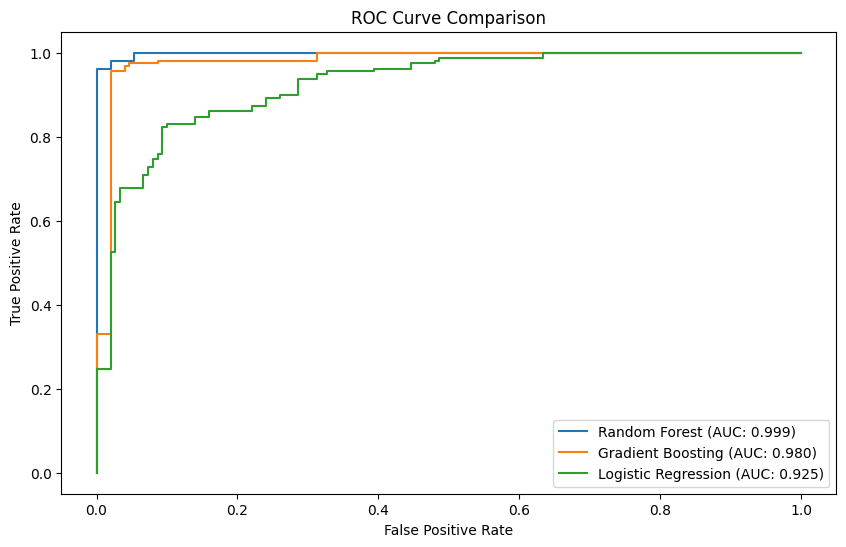

In [90]:
#Співвідношення між True Positive Rate (TPR) і False Positive Rate (FPR).
plt.figure(figsize=(10, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test_scaled if name in ["Logistic Regression"] else X_test)[:, 1]
    else:
        y_pred_prob = model.decision_function(X_test_scaled if name in ["Logistic Regression"] else X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC: {roc_auc_score(y_test, y_pred_prob):.3f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve Comparison")
plt.show()

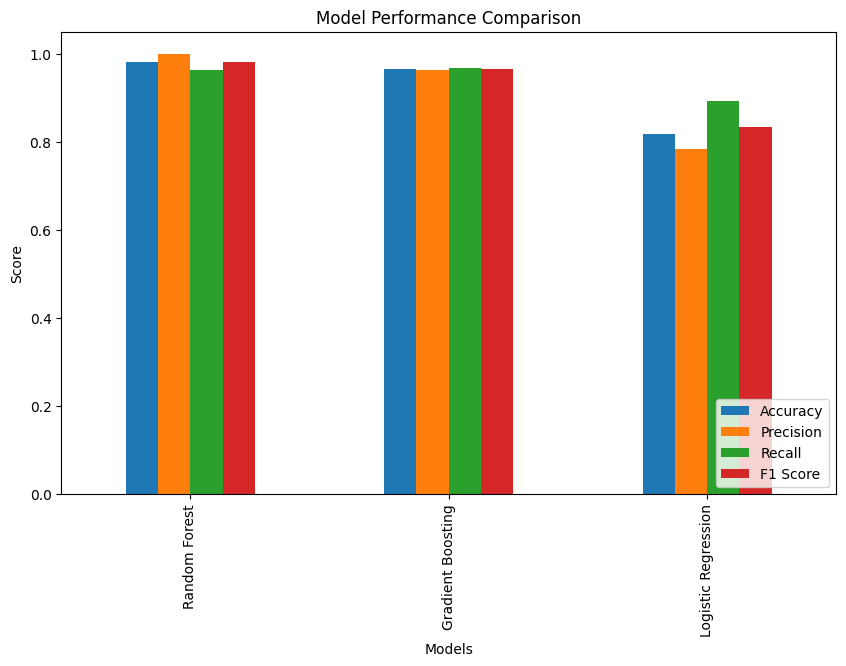

In [91]:
def plot_model_comparison(models, X_test, X_test_scaled, y_test):
    metrics = {"Accuracy": [], "Precision": [], "Recall": [], "F1 Score": []}
    model_names = []

    for name, model in models.items():
        y_pred = model.predict(X_test_scaled if name in ["Logistic Regression"] else X_test)
        metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["Precision"].append(precision_score(y_test, y_pred))
        metrics["Recall"].append(recall_score(y_test, y_pred))
        metrics["F1 Score"].append(f1_score(y_test, y_pred))
        model_names.append(name)

    metrics_df = pd.DataFrame(metrics, index=model_names)
    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xlabel("Models")
    plt.legend(loc="lower right")
    plt.show()

plot_model_comparison(models, X_test, X_test_scaled, y_test)

# Save trained models #

In [136]:
def save_models_pickle(model):
    model_path = f'{model}.joblib'
    joblib.dump(model, model_path)
    print(f'Model saved to {model_path}')
save_models_pickle(forest)

Model saved to RandomForestClassifier().joblib


# Test a predefined set of medical parameters and predict the target using trained models. #

In [92]:
def predict_individual(models, scaler=None):

    # Predefined test input
    test_values = [67,0,0,106,223,0,1,142,0,0.3,2,2,2]  # Example values

    # Create a DataFrame for the input
    user_data = pd.DataFrame([test_values], columns=[
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'
    ])

    # Scale the data if a scaler is provided
    user_data_scaled = scaler.transform(user_data) if scaler else user_data

    # Handle single model or multiple models
    if isinstance(models, dict):
        for name, model in models.items():
            prediction = model.predict(user_data_scaled if name == "Logistic Regression" else user_data)
            print(f"Prediction by {name}: {'Disease' if prediction[0] == 1 else 'No Disease'}")
    else:
        prediction = models.predict(user_data_scaled if scaler else user_data)
        print(f"Prediction: {'Disease' if prediction[0] == 1 else 'No Disease'}")

predict_individual(models, scaler)

Prediction by Random Forest: Disease
Prediction by Gradient Boosting: Disease
Prediction by Logistic Regression: Disease
